# Making a trial by trial fit of faceWord dataand using that for searchligth classificiation

This tutorial will load models and data from tutorial 13 and change the design matrix to one that gives a beta estimate for each trial.

In [ ]:
# import some functionality
from datetime import datetime

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))
import os
import pip
os.system('python3 -m pip install numpy')
os.system('python3 -m pip install matplotlib')
os.system('python3 -m pip install scipy')
os.system('python3 -m pip install panda')
os.system('python3 -m pip install nilearn')
os.system('python3 -m pip install sklearn')
os.system('python3 -m pip install pickle')
os.system('python3 -m pip install atlasreader')

#import os.path as op
import numpy as np
from numpy.linalg import inv
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

%matplotlib inline

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

In [ ]:
import pickle

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

# Getting back the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_our_contrast.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()


now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

In [ ]:
### Figuring out what is in the models_events variable

In [ ]:
#print(models_events[0])
print(models_confounds[0][0].shape)
ons=models_events[0][0]['onset']

for ii in range(len(models_events[0])):
    print(models_events[0][ii])
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Creating new design matrices with a column per experimental trial.

In [ ]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

for ii in range(len(models_events[0])):
    #print(models_events[0][ii])
    #N=number of events
    N=models_events[0][ii].shape[0]
    t_fmri = np.linspace(0, 600,600,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[0][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = ['t_'+str(i).zfill(3) + '_' + models_events[0][0]['trial_type'][i-1]  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        hrf_model='glover',
        drift_model='cosine'  
    ))

# Check out the created design matrix
# Note that the index represents the frame times

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Plot the new design matrices

In [ ]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[0])):
    plot_design_matrix(lsa_dm[ii]);

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Fit the models for all sessions from one participant

In [ ]:

from nilearn.glm.first_level import FirstLevelModel

model1=[]
for ii in range(len(models_events[0])):
    
    # Get data and model info for 1st participant, 1st session
    imgs1=models_run_imgs[0][ii]
    confounds1=models_confounds[0][ii]
    model1.append (FirstLevelModel())
    #Fit the model
    print('Fitting a GLM')
    model1[ii].fit(imgs1,confounds1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Saving/retrieving the fitted models and design matrices

In [ ]:
import pickle

# Saving the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm], f)
f.close()

## Getting back the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm = pickle.load(f)
f.close()

print(model1[0])
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Making z-map contrasts from the fitted model to use in later analyses

In [ ]:

z_maps = []
conditions_label = []

for ii in range(len(models_events[0])):
    N=models_events[0][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    print(contrasts.shape)
    for i in range(N):
        #Add a z-contrast image from each trial
        z_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='z_score'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(models_events[0][ii]['trial_type'][i])
#        session_label.append(session)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Saving models and z_maps

In [ ]:
import pickle

#Save the first level models


# Saving the objects:
#f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_models_all_trials.pkl', 'wb')
#pickle.dump([model1, lsa_dm, conditions_label, z_maps], f)
#f.close()


# Getting back the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, z_maps = pickle.load(f)
f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Reshape data for classification

In [ ]:

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

import numpy as np
#from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img, clean_img
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)
print(n_trials)


# Reshaping data------------------------------
from nilearn.image import index_img, concat_imgs
idx_img = [int(i) for i in range(len(conditions_label)) if conditions_label[i] in ['image_neg', "image_pos"]]
idx_word = [int(i) for i in range(len(conditions_label)) if conditions_label[i] in ['word_pos', "word_neg", "word_neu"]]

#Concatenate trials
idx=np.concatenate((idx_img, idx_word))
conditions=np.array(conditions_label)[idx]

z_maps_conc=concat_imgs(z_maps)
print(z_maps_conc.shape)
z_maps_img = index_img(z_maps_conc, idx)


#from nilearn import plotting

#plotting.plot_img(z_maps_img.get_fdata()[77][91][64][719])

## create training and testing vars on the basis of class labels

In [ ]:
now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))
#conditions_img=conditions[idx]
#print(conditions_img)
#Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx1,idx2, conditions1,  conditions2 = train_test_split(idx2,conditions, test_size=0.2)
print(idx1, idx2)

# Reshaping data------------------------------
from nilearn.image import index_img
fmri_img1 = index_img(z_maps_img, idx1)
fmri_img2 = index_img(z_maps_img, idx2)
#Check data sizes
print(fmri_img1.shape)
print(fmri_img2.shape)

In [ ]:
### Make a classification on the 2nd split using the best voxels

In [ ]:

# Getting back the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_our_contrast.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()
import nibabel as nib
test_img = nib.load(models_run_imgs[1][1])

<class 'nibabel.nifti1.Nifti1Image'>
3519


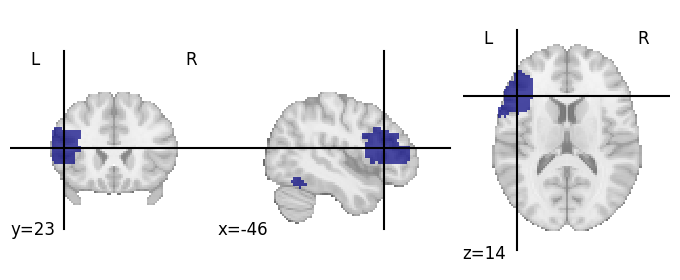

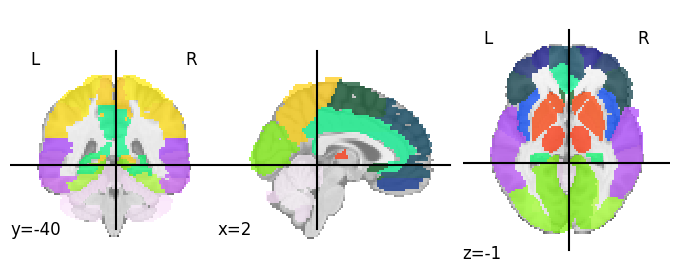

In [62]:
import nilearn
from nilearn import plotting
atlas_name = "SPM12"

atlas = nilearn.datasets.fetch_atlas_aal(atlas_name, data_dir="/work/fMRI Assignment/neuro_exam/atlases", resume=True, verbose=1)

# atlas_name = "maxprob-thr50-2mm"

# atlas = nilearn.datasets.fetch_atlas_juelich(atlas_name, data_dir="/work/fMRI Assignment/neuro_exam/atlases", symmetric_split=False, resume=True, verbose=1)

# PREPARING ATLAS
atlas_img = nib.load(atlas["maps"])
print(type(atlas_img))
# Get labels
labels = atlas.labels
atlas_data = atlas_img.get_fdata()

from nilearn.image import resample_img as resample

target_affine = test_img.affine

shape = test_img.shape
target_shape = [shape[0], shape[1], shape[2]]

resampled_atlas =resample(atlas_img,target_affine = target_affine, target_shape = target_shape, interpolation = 'nearest')

resamp_data = resampled_atlas.get_fdata()

mask = resamp_data.copy()


x = resamp_data.shape[0]
y = resamp_data.shape[1]
z = resamp_data.shape[2]

# This will set all elements of atlas_data to either 0 or 1.
m = 0
for i in range(0, x):
    for j in range(0, y):
        for k in range(0, z):
            if resamp_data[i][j][k] in [2301,2311,5401,5402]:
                m += 1
                mask[i][j][k] = 1
            else:
                mask[i][j][k] = 0
print(m)

mask_nifti = nib.Nifti1Image(mask, affine = target_affine)
plotting.plot_roi(mask_nifti)
plotting.plot_roi(atlas_img)

In [67]:
from nilearn.input_data import NiftiMasker
from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB as nb
masker = NiftiMasker(mask_img=mask_nifti, standardize=False)



# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked_train = masker.fit_transform(fmri_img1)
fmri_masked_test = masker.fit_transform(fmri_img2)
#Print size of matrix (images x voxels)
# print(fmri_masked.shape)

lin_clf = LinearSVC(penalty = "l2")

lin_clf.fit(fmri_masked_train, conditions1)

from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lin_clf, fmri_masked_test, conditions2, cv=10)
print(cv_score)
print('Mean prediction score:')
print(np.mean(cv_score))

[0.4        0.2        0.26666667 0.13333333 0.28571429 0.28571429
 0.07142857 0.35714286 0.21428571 0.28571429]
Mean prediction score:
0.25


In [39]:
print(fmri_masked_train.shape)
print(conditions1.shape)

(576, 462)
(576,)


### Perform a permutation test

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue= permutation_test_score(
    LinearSVC(penalty='l2'), fmri_masked, conditions2, cv=10, n_permutations=100, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score, pvalue))

### View a histogram of permutation scores

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#How many classes
n_classes = np.unique(conditions2).size

plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()